Cross Exchange funding bot


=== FINAL SUMMARY ===
Initial Balance: $10000.00
Final Balance:   $10000.00
Total Profit:    $0.00
Total Trades:    0
No trades
N/A


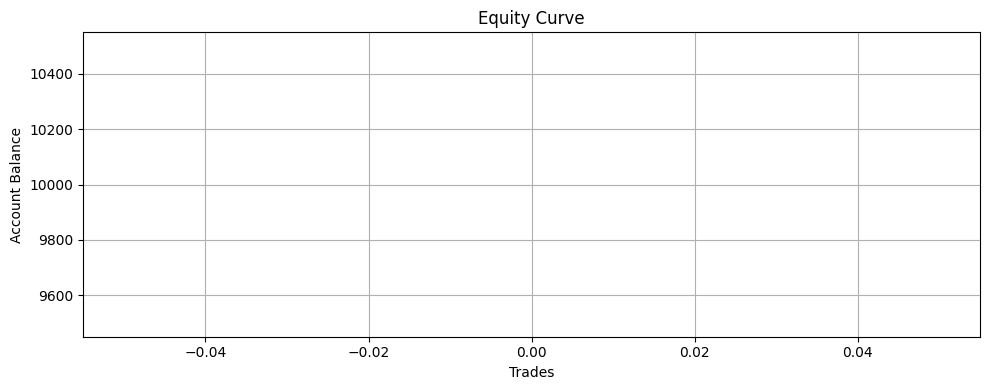


Trades saved to cross_exchange_trades.csv


In [7]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN
import matplotlib.pyplot as plt

# === Load and preprocess ===
kucoin_df = pd.read_csv("dataset/kucoin_funding_with_futures_prices.csv")
binance_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")

kucoin_df['timestamp'] = pd.to_datetime(kucoin_df['Time'])
binance_df['timestamp'] = pd.to_datetime(binance_df['timestamp'])
kucoin_df['funding_rate'] = pd.to_numeric(kucoin_df['Funding Rate'], errors='coerce')

kucoin_df = kucoin_df.rename(columns={
    'Futures Closing Price': 'kucoin_futures',
    'Spot Closing Price': 'kucoin_spot'
})

# Sort for merge_asof
kucoin_df = kucoin_df.sort_values('timestamp')
binance_df = binance_df.sort_values('timestamp')

# Merge Binance spot to KuCoin timestamps
merged = pd.merge_asof(
    kucoin_df,
    binance_df[['timestamp', 'close_spot']],
    on='timestamp',
    direction='backward'
)

# Drop rows without match
merged = merged.dropna(subset=['close_spot'])

# === Parameters ===
initial_balance = 10000
account_balance = initial_balance
base_funding_rate = 0.0003
min_expected_profit = 0.01
base_holding_hours = 120
funding_interval = 8
risk_per_trade_pct = 0.01
max_trade_size = 0.4
use_taker = False

# Fees
spot_taker_fee = 0.001
futures_taker_fee = 0.0004
spot_maker_fee = 0.001
futures_maker_fee = 0.0002

spot_fee = spot_taker_fee if use_taker else spot_maker_fee
futures_fee = futures_taker_fee if use_taker else futures_maker_fee

# === State ===
position_id = 0
open_positions = []
total_profit = 0
all_pnls = []
trade_log = []

# === Helpers ===
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def calculate_position_size(balance, entry_price):
    risk = balance * risk_per_trade_pct
    size = risk / entry_price
    return round_trade_size(min(size, max_trade_size))

def get_fees(size, spot, futures):
    return size * spot * spot_fee * 2 + size * futures * futures_fee * 2

def calculate_funding(size, rate, price):
    return size * rate * price * (base_holding_hours / funding_interval)

# === Run Bot ===
for i, row in merged.iterrows():
    ts = row['timestamp']
    funding = row['funding_rate']
    kucoin_fut = row['kucoin_futures']
    binance_spot = row['close_spot']

    # Close matured positions
    for pos in open_positions[:]:
        if ts >= pos['target_close_time']:
            hours = (ts - pos['entry_time']).total_seconds() / 3600
            funding_pnl = pos['size'] * pos['funding_rate'] * pos['futures_price'] * (hours / funding_interval)
            if pos['direction'] == 'positive':
                spot_pnl = pos['size'] * (binance_spot - pos['spot_price'])
                fut_pnl = pos['size'] * (pos['futures_price'] - kucoin_fut)
            else:
                spot_pnl = pos['size'] * (pos['spot_price'] - binance_spot)
                fut_pnl = pos['size'] * (kucoin_fut - pos['futures_price'])

            fee = get_fees(pos['size'], pos['spot_price'], kucoin_fut)
            pnl = funding_pnl + spot_pnl + fut_pnl - fee
            total_profit += pnl
            account_balance += pnl
            all_pnls.append(pnl)
            open_positions.remove(pos)

            trade_log.append({
                'entry_time': pos['entry_time'],
                'exit_time': ts,
                'entry_spot': pos['spot_price'],
                'exit_spot': binance_spot,
                'entry_futures': pos['futures_price'],
                'exit_futures': kucoin_fut,
                'funding_rate': pos['funding_rate'],
                'funding_profit': funding_pnl,
                'fees': fee,
                'total_pnl': pnl,
                'hours_held': round(hours, 2),
                'direction': pos['direction']
            })

    # Open new positions
    if ((funding > 0 and funding >= base_funding_rate) or funding < 0):
        size = calculate_position_size(account_balance, kucoin_fut)
        margin_needed = size * kucoin_fut
        if margin_needed <= account_balance * 0.9:
            exp_funding = calculate_funding(size, funding, kucoin_fut)
            fees = get_fees(size, binance_spot, kucoin_fut)
            net = (exp_funding - fees) if funding > 0 else (-exp_funding - fees)

            if net > min_expected_profit:
                open_positions.append({
                    'id': position_id,
                    'entry_time': ts,
                    'target_close_time': ts + pd.Timedelta(hours=base_holding_hours),
                    'spot_price': binance_spot,
                    'futures_price': kucoin_fut,
                    'funding_rate': funding,
                    'size': size,
                    'direction': 'positive' if funding > 0 else 'negative'
                })
                position_id += 1

# === Summary ===
print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance:   ${account_balance:.2f}")
print(f"Total Profit:    ${total_profit:.2f}")
print(f"Total Trades:    {len(all_pnls)}")
print(f"Win Rate:        {sum(p > 0 for p in all_pnls) / len(all_pnls) * 100:.2f}%" if all_pnls else "No trades")
print(f"Avg Profit/Trade:${np.mean(all_pnls):.2f}" if all_pnls else "N/A")

# === Charts ===
equity = [initial_balance]
for p in all_pnls:
    equity.append(equity[-1] + p)

plt.figure(figsize=(10,4))
plt.plot(equity)
plt.title("Equity Curve")
plt.xlabel("Trades")
plt.ylabel("Account Balance")
plt.grid(True)
plt.tight_layout()
plt.show()

trade_df = pd.DataFrame(trade_log)
trade_df.to_csv("cross_exchange_trades.csv", index=False)
print("\nTrades saved to cross_exchange_trades.csv")